Import libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline

/home/somanshu/anaconda3/envs/mfe-preprogram_new/lib/python3.8/site-packages/papermill/iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


Define the required functions for return, volatility and max drawdown(MDD)

In [2]:
## Return function
def hourly_return(x):
    return x.pct_change()


## Max Drawdown
def max_drawdown(x):
    cum_max = x.cummax()
    dd = (x - x.cummax())/x
    return dd.cummin()    

## Volatility function : as discussed in class
def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

Define the parameters of the notebook

In [3]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///../../../Lectures/Lecture 4/data/data.db'

In [4]:
# Parameters
from_date = "2021-11-29"
to_date = "2021-12-06"
token = "BTC"
connection_string = "sqlite:///../../../Lectures/Lecture 4/data/data.db"


Read the data using read_sql

In [5]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])
prices.sort_values('ts',inplace=True)
prices.set_index('ts', inplace=True)

prices.head()

,open,high,low,close,volume,volumeUSD,token,chain
ts,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC


Calculate the required metrics

In [6]:
prices['returns'] = hourly_return(prices.close)
prices['drawdown'] = max_drawdown(prices.close)
prices['volatility'] = vol_ohlc(prices)
prices.head(20)

,open,high,low,close,volume,volumeUSD,token,chain,returns,drawdown,volatility
ts,,,,,,,,,,,
2021-11-29 00:00:00,56075.51,57490.00,56075.51,57317.17,993.419376,5.675379e+07,BTC,BTC,NaN,0.000000,NaN
2021-11-29 01:00:00,57318.51,58003.80,57183.06,57809.41,1140.750133,6.567139e+07,BTC,BTC,0.008588,0.000000,NaN
2021-11-29 02:00:00,57809.40,58280.36,57570.02,57690.56,911.058672,5.268191e+07,BTC,BTC,-0.002056,-0.002060,NaN
2021-11-29 03:00:00,57690.57,57764.76,57338.09,57359.92,592.329247,3.410836e+07,BTC,BTC,-0.005731,-0.007836,NaN
2021-11-29 04:00:00,57360.32,57472.34,57243.53,57408.85,412.284052,2.365137e+07,BTC,BTC,0.000853,-0.007836,NaN
2021-11-29 05:00:00,57408.85,57718.41,57303.58,57317.48,525.014024,3.018284e+07,BTC,BTC,-0.001592,-0.008583,NaN
2021-11-29 06:00:00,57318.50,57455.91,57275.97,57400.00,370.608080,2.125206e+07,BTC,BTC,0.001440,-0.008583,NaN
2021-11-29 07:00:00,57400.00,57610.83,57400.00,57496.96,407.093736,2.340534e+07,BTC,BTC,0.001689,-0.008583,NaN
2021-11-29 08:00:00,57496.96,57739.52,57453.70,57577.92,252.657112,1.454988e+07,BTC,BTC,0.001408,-0.008583,NaN


Define the plotting function

In [7]:
def series_plot(data, ax=None):
    data.plot(ax=ax)
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.rainbow(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

In [8]:
%%capture

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))

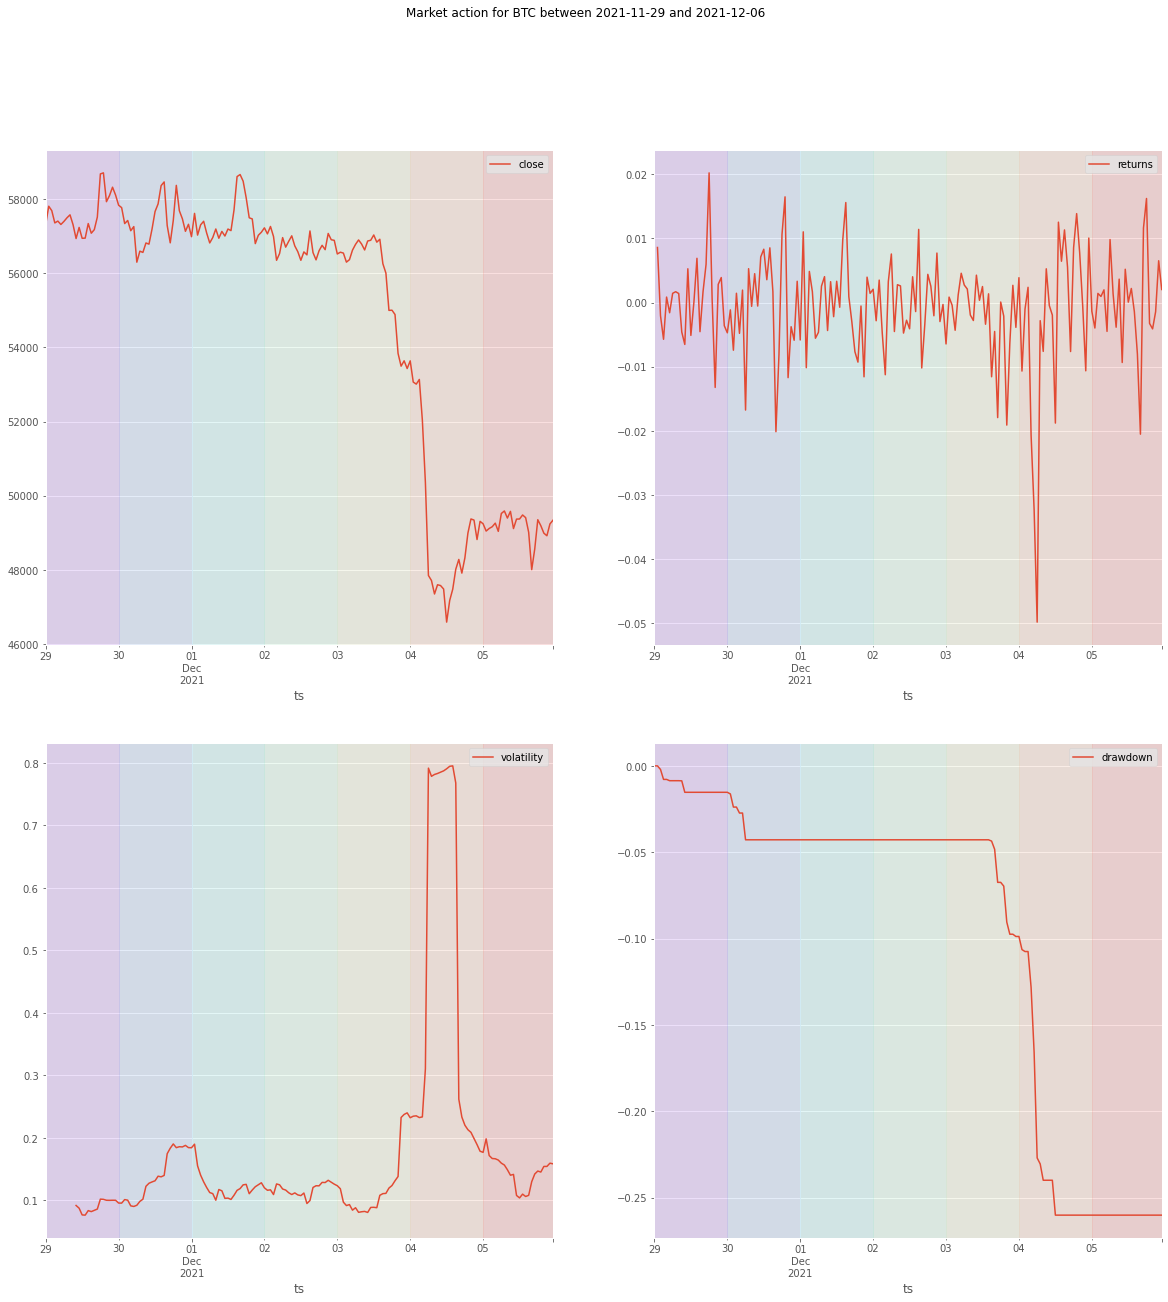

In [9]:
series_plot(prices[['close']], ax=ax[0, 0])
series_plot(prices[['returns']], ax=ax[0, 1])
series_plot(prices[['volatility']], ax=ax[1, 0])
series_plot(prices[['drawdown']], ax=ax[1, 1])
fig.suptitle(f'Market action for {token} between {from_date} and {to_date}')
fig

Glue the required variables to scrapbook

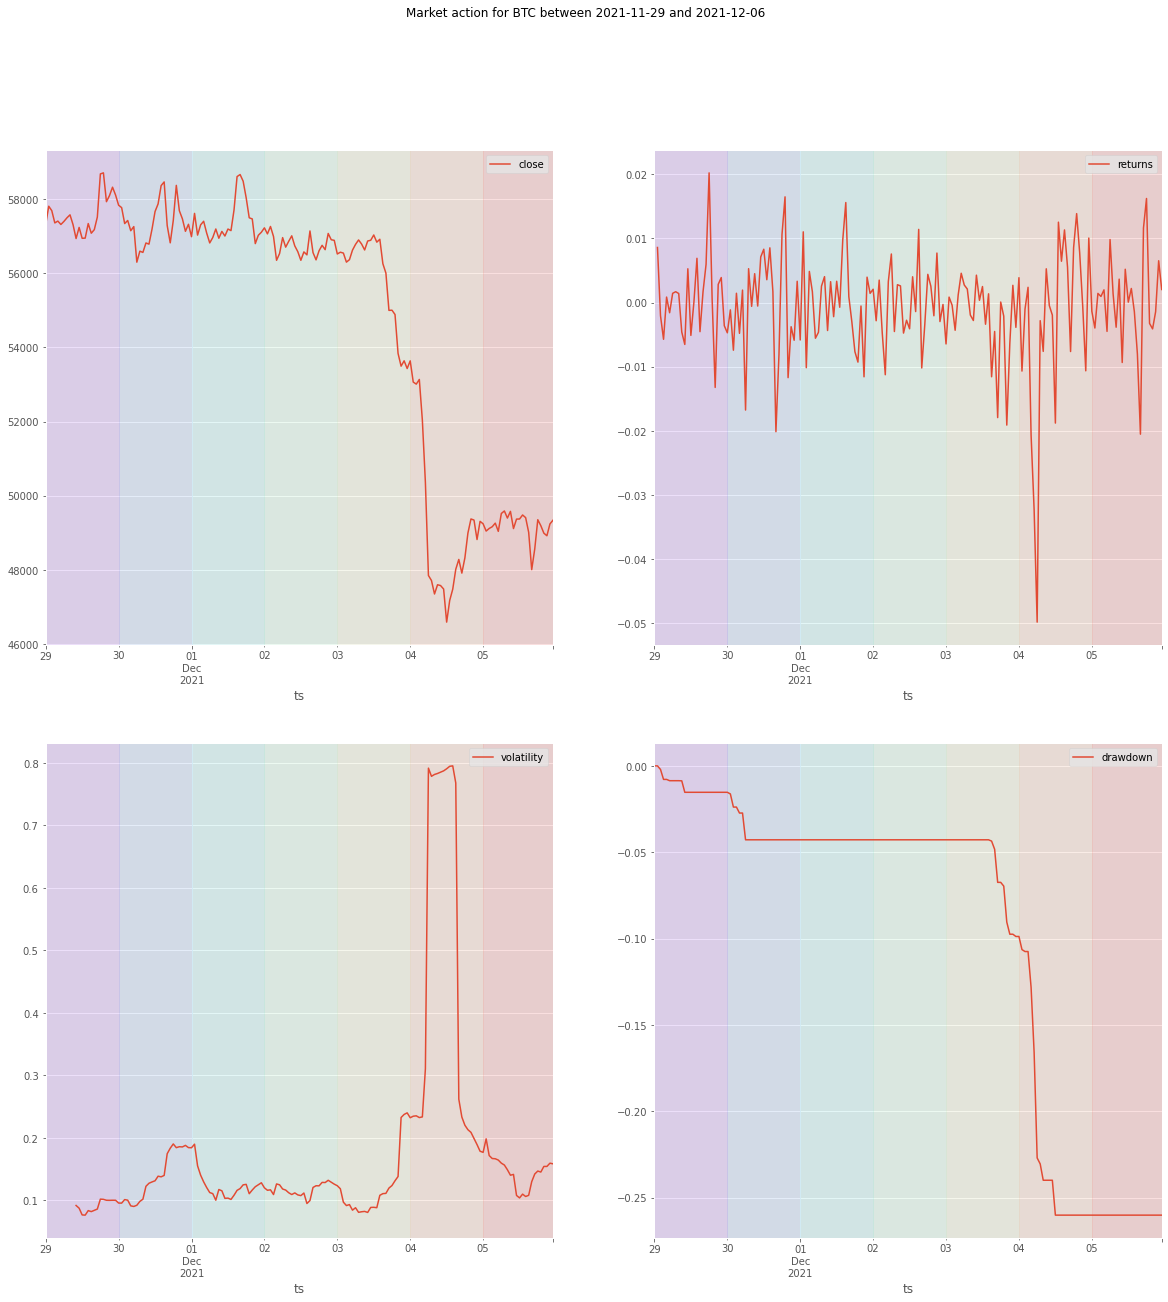

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)